In [256]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import gensim
import string

In [257]:
# Read the training and testing datasets
train_path = "../data/data-clean/cleaned_train.csv"
test_path = "../data/data-clean/all_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Toxicity

In [258]:
feature = train_df[['comment_text']]
output = train_df[['target']] 

In [259]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)

# Bag of Word

In [260]:
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [261]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.027844622374673278
Mean Squared Error on cv set:  0.026980733119644787
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.029137188516118854
Mean Squared Error on cv set:  0.028102991922892187
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03258898425985887
Mean Squared Error on cv set:  0.031059837402473818
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.026494316096529653
Mean Squared Error on cv set:  0.025918895654985046
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.028712339977638956
Mean Squared Error on cv set:  0.02740346788101636
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error o

In [262]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [263]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.392428
idiot,0.182188
crap,0.094509
shit,0.087531
fuck,0.080585
white,0.060375
damn,0.053492
need,0.009294
racist,0.008793
state,0.007312


In [264]:
test_preds = best_model.predict(bow_test)

In [265]:
test_df['predicted_target'] = test_preds

# obscene

In [266]:
feature = train_df[['comment_text']]
output = train_df[['obscene']] 

In [267]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [268]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['obscene'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['obscene'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003852674675173767
Mean Squared Error on cv set:  0.0031025722721113717
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0053546552422458924
Mean Squared Error on cv set:  0.004368470124842318
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.005453124413820992
Mean Squared Error on cv set:  0.004465980971537929
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003232896827505672
Mean Squared Error on cv set:  0.002882715645971403
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.005340351866792326
Mean Squared Error on cv set:  0.004368025956088694
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Err

In [269]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [270]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
fuck,0.294531
shit,0.239410
damn,0.127157
crap,0.124664
ass,0.108923
idiot,0.038333
darn,0.031181
work,0.015108
like,0.007912
give,0.005974


In [271]:
test_preds = best_model.predict(bow_test)
test_df['predicted_obscene'] = test_preds

# identity_attack

In [272]:
feature = train_df[['comment_text']]
output = train_df[['identity_attack']]

In [273]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [274]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['identity_attack'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['identity_attack'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0038778977083623084
Mean Squared Error on cv set:  0.0038034694192178886
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.004159742796016517
Mean Squared Error on cv set:  0.0039973452198680684
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0048683893003081775
Mean Squared Error on cv set:  0.004581649324471107
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003636946636616474
Mean Squared Error on cv set:  0.0036565782122243485
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.004068479469110963
Mean Squared Error on cv set:  0.003919419556340099
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared 

In [275]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [276]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]
test_preds = best_model.predict(bow_test)
test_df['predicted_identity_attack'] = test_preds

In [277]:
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
white,0.409359
gay,0.257668
black,0.069388
homosexu,0.069088
muslim,0.059689
white hous,0.034622
white peopl,0.025212
go,0.021452
nativ,0.015553
dont,0.014900


# insult

In [278]:
feature = train_df[['comment_text']]
output = train_df[['insult']] 
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [279]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['insult'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['insult'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.02046855681494743
Mean Squared Error on cv set:  0.019534348686417572
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.02153318949652013
Mean Squared Error on cv set:  0.020608162713028344
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.024885609638873724
Mean Squared Error on cv set:  0.023397247783102332
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.019576115411698146
Mean Squared Error on cv set:  0.019167159895962495
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.021255129675314247
Mean Squared Error on cv set:  0.0203210766246132
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on 

In [280]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [281]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.430534
idiot,0.211666
ridicul,0.065206
crap,0.058586
ignor,0.056680
dumb,0.056186
fuck,0.054561
one,0.012351
need,0.010200
like,0.008296


In [282]:
test_preds = best_model.predict(bow_test)
test_df['predicted_insult'] = test_preds

# threat

In [283]:
feature = train_df[['comment_text']]
output = train_df[['threat']] 
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=6000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [284]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['threat'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['threat'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0020159770385689193
Mean Squared Error on cv set:  0.002270269620655003
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0020591539625161356
Mean Squared Error on cv set:  0.002256625227283155
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0022558277879534566
Mean Squared Error on cv set:  0.0024958560136284524
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0019496492466681882
Mean Squared Error on cv set:  0.0022669194316674024
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0020451886535109483
Mean Squared Error on cv set:  0.002245748640190827
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Square

In [285]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [286]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
kill,0.547052
shoot,0.277411
death,0.073833
shot,0.043069
gun,0.019991
die,0.018149
head,0.015724
peopl,0.004771
poop,0.000000
populac,0.000000


In [287]:
test_preds = best_model.predict(bow_test)
test_df['predicted_threat'] = test_preds
test_df.to_csv('../data/data-predict/DecisionTreeRegressor_test_predictions.csv', index=False)

# Toxicity EDA

In [288]:
print(test_df['predicted_target'].describe())

count    342.000000
mean       0.119709
std        0.168899
min        0.069632
25%        0.069632
50%        0.069632
75%        0.069632
max        0.758003
Name: predicted_target, dtype: float64


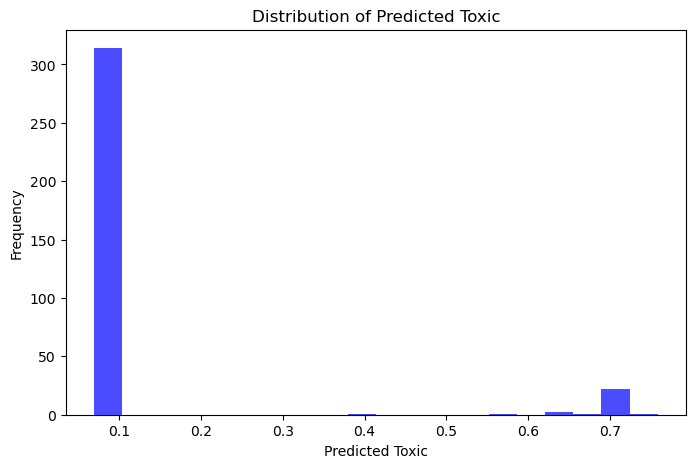

In [304]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_target'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Toxic")
plt.xlabel("Predicted Toxic")
plt.ylabel("Frequency")
plt.show()

In [290]:
top_predictions = test_df.sort_values(by='predicted_target', ascending=False).head(10)
print(top_predictions[['text', 'predicted_target']])

low_predictions = test_df.sort_values(by='predicted_target', ascending=True).head(10)
print(low_predictions[['text', 'predicted_target']])

                                                  text  predicted_target
0    thefrogsoupram bluerei naegiko didnt consent a...          0.758003
18   everyon support ai look good monster planet fu...          0.700567
190  talanhorn hate perform hate ai protect dont ne...          0.700567
192  rt sladeneverdi shit look like made ai disney ...          0.700567
193  seen someon describ clever ai art prompt cleve...          0.700567
199  shit look like made ai disney becom hous soull...          0.700567
120  monachikosx charismaticgeto alreadi put place ...          0.700567
234  art verg death soulless ai shit art art feel code          0.700567
236  ai creator lie shit fuck ugliest soulless bull...          0.700567
255  quit soulless plu look like shit id say ai stu...          0.700567
                                                  text  predicted_target
171    one hand ai art exploit hand least ruin environ          0.069632
228                            call ai soulless rea

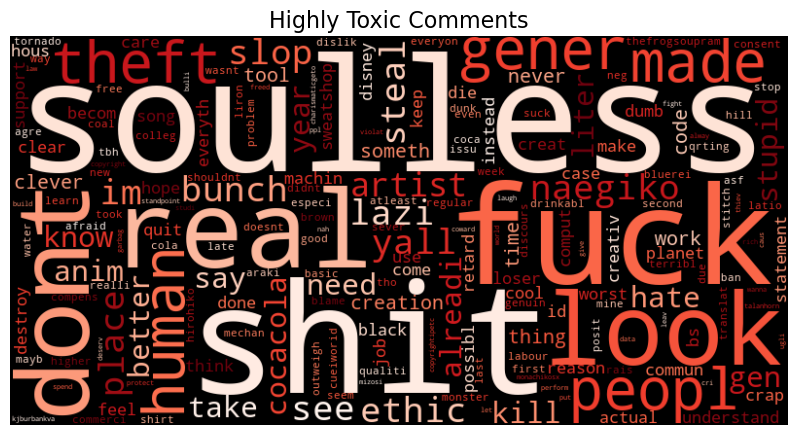

In [291]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_toxic_comments = test_df[test_df['predicted_target'] > high_toxic_threshold]['text'].values
high_toxic_text = " ".join(high_toxic_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_toxic_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_toxic_text)
else:
    print("No high toxic comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_toxic_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Toxic Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()


## obscene

In [292]:
print(test_df['predicted_obscene'].describe())

count    342.000000
mean       0.056506
std        0.163939
min        0.009150
25%        0.009150
50%        0.009150
75%        0.009150
max        0.648587
Name: predicted_obscene, dtype: float64


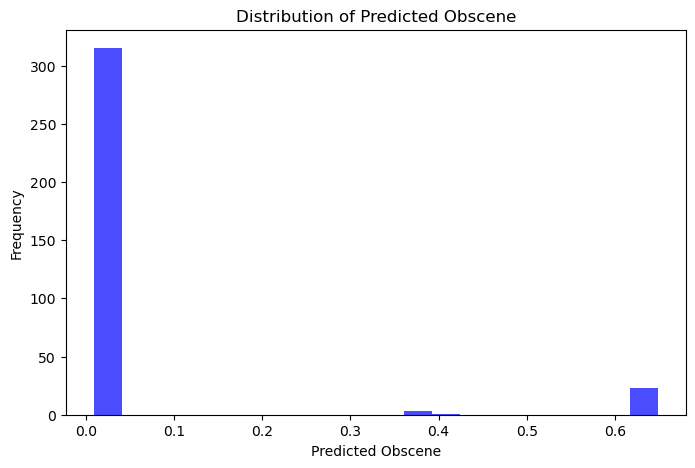

In [293]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_obscene'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Obscene")
plt.xlabel("Predicted Obscene")
plt.ylabel("Frequency")
plt.show()

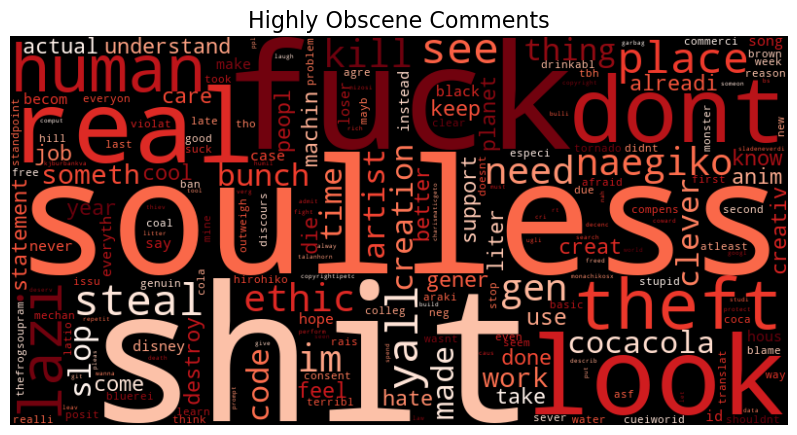

In [294]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_obscene_comments = test_df[test_df['predicted_obscene'] > high_toxic_threshold]['text'].values
high_obscene_text = " ".join(high_obscene_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_obscene_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_obscene_text)
else:
    print("No high obscene comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_obscene_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Obscene Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

## identity_attack

In [295]:
print(test_df['predicted_identity_attack'].describe())

count    342.000000
mean       0.012269
std        0.005699
min        0.011833
25%        0.011833
50%        0.011833
75%        0.011833
max        0.086471
Name: predicted_identity_attack, dtype: float64


In [296]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_obsence'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Identity Attack")
plt.xlabel("Predicted Identity Attack")
plt.ylabel("Frequency")
plt.show()

KeyError: 'predicted_obsence'

<Figure size 800x500 with 0 Axes>

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_ia_comments = test_df[test_df['predicted_identity_attack'] > high_toxic_threshold]['text'].values
high_ia_text = " ".join(high_ia_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_ia_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_ia_text)
else:
    print("No high identity attack comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_ia_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Identity Attack Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

No high identity attack comments available for word cloud!


<Figure size 1600x800 with 0 Axes>

## insult

In [ ]:
print(test_df['predicted_insult'].describe())

count    342.000000
mean       0.071250
std        0.097704
min        0.050236
25%        0.050236
50%        0.050236
75%        0.050236
max        0.714464
Name: predicted_insult, dtype: float64


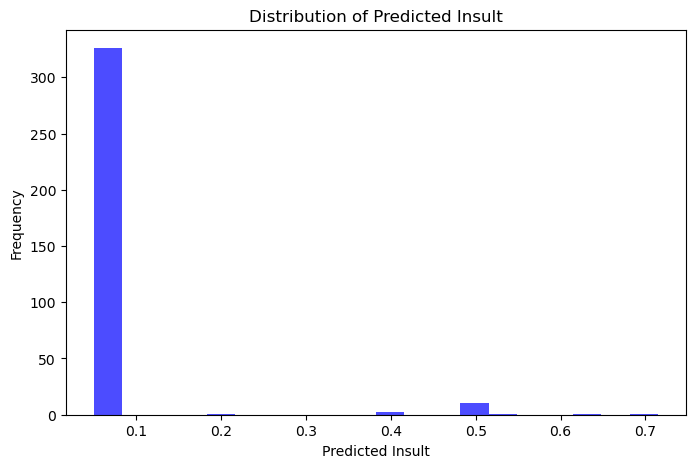

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_insult'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Insult")
plt.xlabel("Predicted Insult")
plt.ylabel("Frequency")
plt.show()

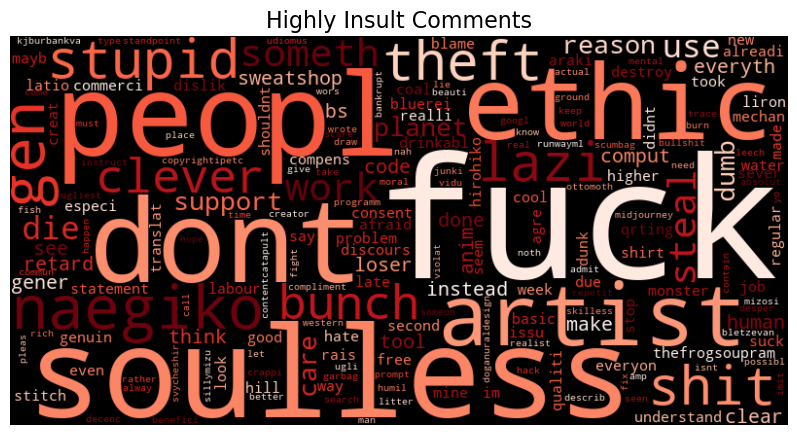

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_insult_comments = test_df[test_df['predicted_insult'] > high_toxic_threshold]['text'].values
high_insult_text = " ".join(high_insult_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_insult_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_insult_text)
else:
    print("No high insult comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_insult_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Insult Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

# threat

In [ ]:
print(test_df['predicted_threat'].describe())

count    342.000000
mean       0.011625
std        0.021393
min        0.005053
25%        0.005053
50%        0.005053
75%        0.005053
max        0.088155
Name: predicted_threat, dtype: float64


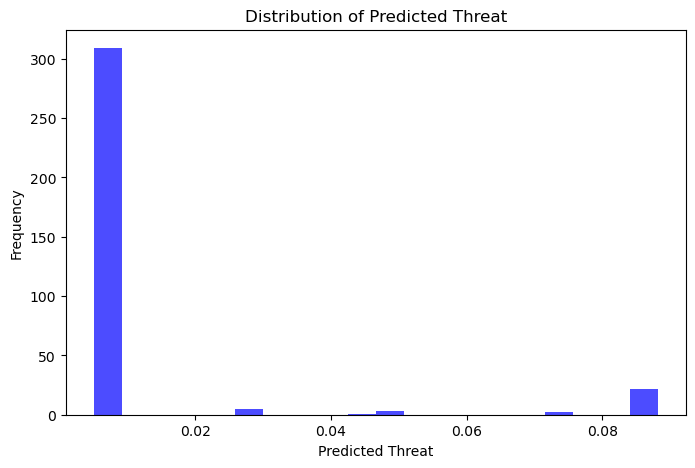

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_threat'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Threat")
plt.xlabel("Predicted Threat")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_threat_comments = test_df[test_df['predicted_threat'] > high_toxic_threshold]['text'].values
high_threat_text = " ".join(high_threat_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_threat_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_threat_text)
else:
    print("No high threat comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_threat_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Threat Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

No high threat comments available for word cloud!


<Figure size 1600x800 with 0 Axes>

d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


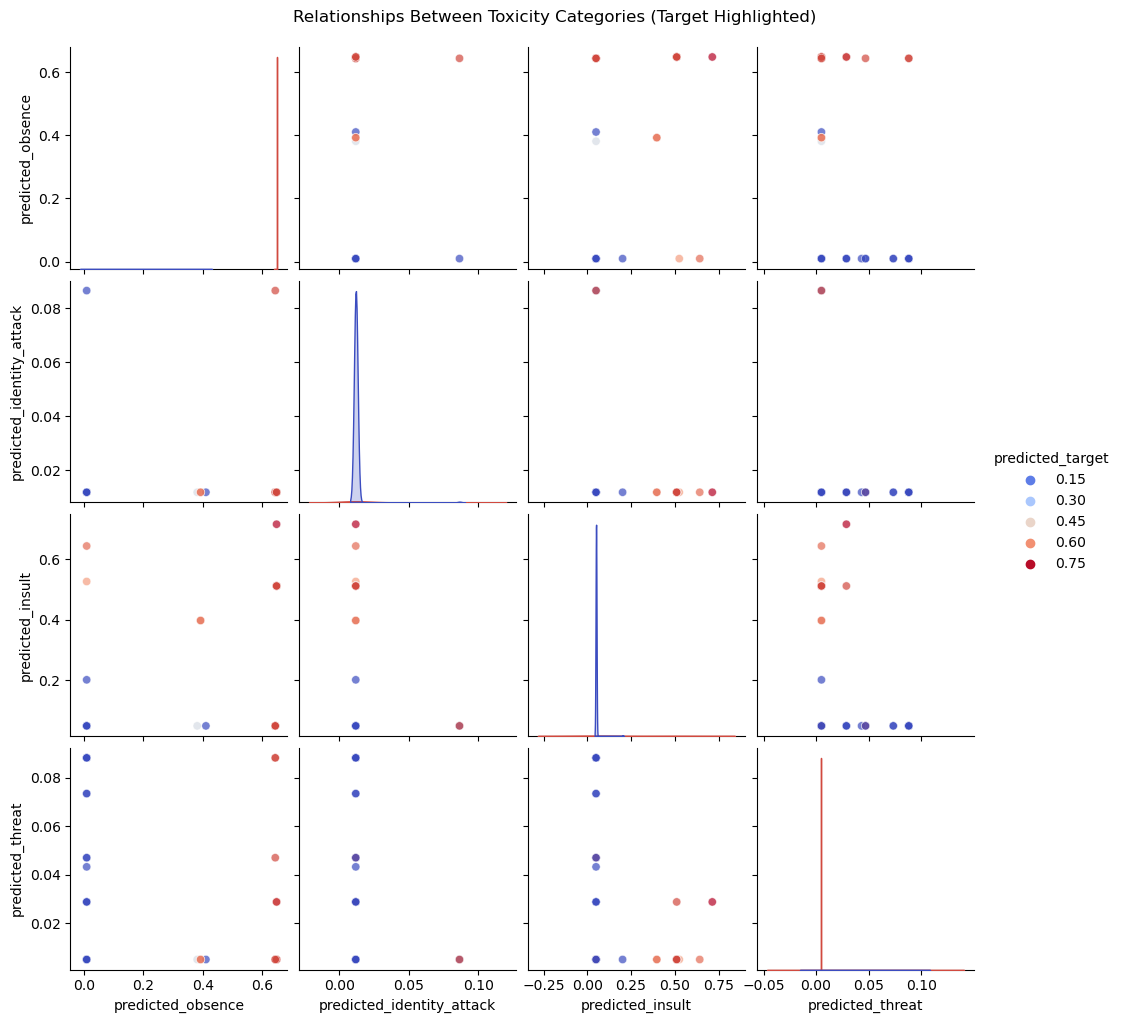

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

toxic_categories = ['predicted_obscene', 'predicted_identity_attack', 'predicted_insult', 'predicted_threat']

sns.pairplot(data=test_df, vars=toxic_categories, diag_kind='kde',
             hue='predicted_target', palette='coolwarm', plot_kws={'alpha': 0.7})
plt.suptitle("Relationships Between Toxicity Categories (Target Highlighted)", y=1.02)
plt.show()

d:\conda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


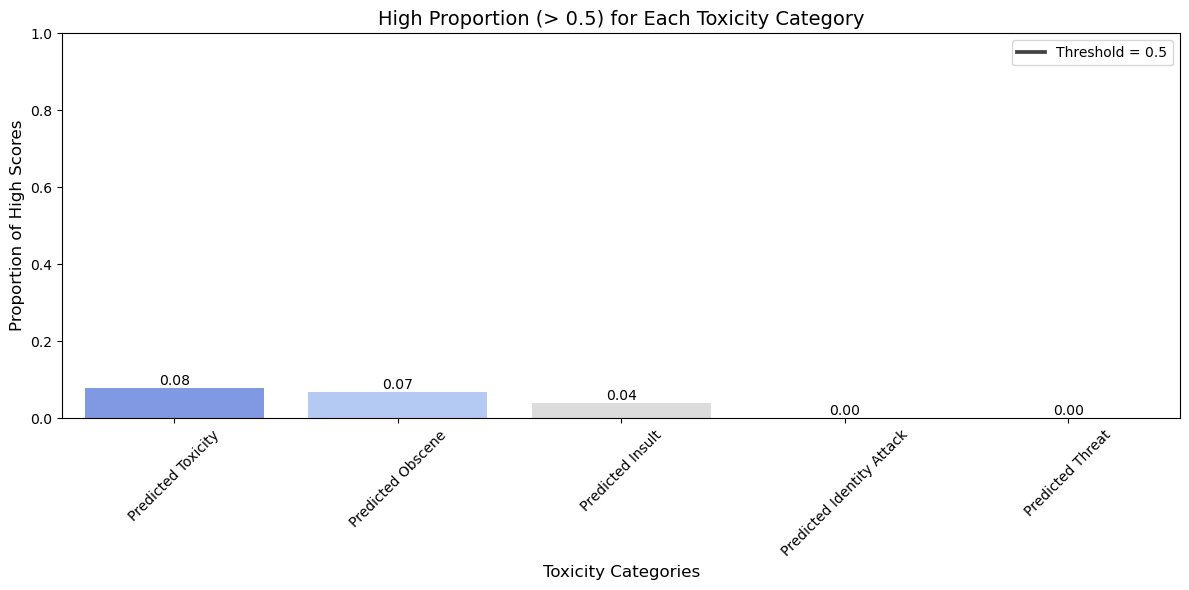

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the threshold
threshold = 0.5

# Toxic categories to analyze
toxic_categories = {
    'predicted_target': 'Predicted Toxicity',
    'predicted_obscene': 'Predicted Obscene',
    'predicted_identity_attack': 'Predicted Identity Attack',
    'predicted_insult': 'Predicted Insult',
    'predicted_threat': 'Predicted Threat'
}

# Calculate the high proportion for each category
high_proportions = {}
for category, label in toxic_categories.items():
    high_proportions[label] = (test_df[category] > threshold).mean()

# Convert to a sorted list for visualization
high_proportions_sorted = dict(sorted(high_proportions.items(), key=lambda x: x[1], reverse=True))

# Plot the high proportions
plt.figure(figsize=(12, 6))
bars = sns.barplot(
    x=list(high_proportions_sorted.keys()),
    y=list(high_proportions_sorted.values()),
    palette='coolwarm'
)

# Add titles and labels
plt.title("High Proportion (> 0.5) for Each Toxicity Category", fontsize=14)
plt.ylabel("Proportion of High Scores", fontsize=12)
plt.xlabel("Toxicity Categories", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add bar labels to show values
for bar in bars.patches:
    value = bar.get_height()
    bars.annotate(f"{value:.2f}", (bar.get_x() + bar.get_width() / 2, value), 
                  ha='center', va='bottom', fontsize=10, color='black')

# Add legend
plt.legend(["Threshold = 0.5"], loc='upper right', fontsize=10, frameon=True)

# Show plot
plt.tight_layout()
plt.show()